In [1]:
"Add an introduction and description of symphony here maybe"

'Add an introduction and description of symphony here maybe'

In [1]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import pandas as pd
from typing import List, Dict
import rioxarray
import rasterio
from glob import glob
from collections import defaultdict, OrderedDict
from mpl_toolkits.basemap import Basemap
from fuzzywuzzy import process
import pdb

In [2]:
#Define path and one file example
PATH_WIO = "/Users/xavierpivan/HubOcean/wiosym/products/v2.1/output_geotiffs/"
PATH_SENSITIVITY = "/Users/xavierpivan/HubOcean/data/WIO_Symphony/"

sensitivity_path = PATH_SENSITIVITY+"Sensitivity Matrix 20220224.xlsx"

ecosystem_path = PATH_WIO+"eco/"
pressure_path = PATH_WIO+"pres/"

eco_files_list = glob(ecosystem_path+'*.tif')
pres_files_list = glob(pressure_path+'*.tif')

In [3]:
#Function toolbox
#TODO create a .py that store this toolbox
def get_variable_mapped(files_list: List, path: str) -> Dict:
    mapping_var_name_to_file = {}
    for file in files_list:
        name_var_from_file_list = file.replace(path, "").replace(".tif", "").replace("_", " ")
        mapping_var_name_to_file[name_var_from_file_list] = file       
    return mapping_var_name_to_file



def load_data(file: str) -> np.array:
    with rasterio.open(file) as src:
        data = src.read()
    return np.array(data[0])



def find_most_similar(list1: List, list2: List) -> Dict[str, int]:
    similarity_dict = {}
    for item1 in list1:
        most_similar_item, similarity = process.extractOne(item1, list2)
        similarity_dict[item1] = (most_similar_item, similarity)        
    return similarity_dict



def map_symphony_var_name_to_file_location(eco_files_list: List, ecosystem_path: str) -> Dict:
    mapping = {}
    mapping[get_variable_list(eco_files_list, ecosystem_path)] =  eco_files_list



def filtering_dupli(most_similar_variable: dict) -> (defaultdict, dict):
    dup = defaultdict(int)
    dup['dup_2_remove'] = []
    for (name_sens, (name_symp, sim)) in most_similar_variable.items():
        if type(dup[name_symp]) is int:
            dup[name_symp]=(name_sens, sim)
        else:
            if sim>dup[name_symp][1]:
                dup[name_symp]=(name_sens, sim)
            else:
                dup['dup_2_remove'].append((name_sens,(name_symp, sim)))#(((name_symp,dup[name_symp]),(name_sens,(name_symp, sim))))
    return (most_similar_variable, dup['dup_2_remove'])



def rename_sensitivity_matrix(df_sensitivity: pd.DataFrame, most_similar_species: List, 
                              most_similar_pressure: List)-> pd.DataFrame:
    
    rename_map = {}
    index_species_sensitivity = df_sensitivity.index.get_level_values(1)
    col_pressure_sensitivity = df_sensitivity.columns.get_level_values(1)
    for i in index_species_sensitivity:
        rename_map[i] = most_similar_species[i][0]
    for i in col_pressure_sensitivity:
        rename_map[i] = most_similar_pressure[i][0]
    return df_sensitivity.rename(index=rename_map, columns=rename_map)



def generate_eco_or_pres_matrix(mapping_var_file: Dict, level_list: List, lat: np.ndarray, lon: np.ndarray) -> np.ndarray:
    data = np.zeros((len(level_list), len(lat), len(lon)))
    for i, sensi in enumerate(level_list):
        data[i,:] = load_data(mapping_var_file[sensi])
    return np.ma.masked_where(data>100, data)



def plot_symphony(lon: np.array, lat: np.array, var: np.ndarray, cmap=plt.cm.jet, 
                  label_colorbar=None, title=None, savefig_path=None, show=None) -> None:
    fig = plt.figure(figsize=(13, 8))

    m = Basemap(resolution=None,
                width=20000, height=50000,
                llcrnrlon=10,llcrnrlat=18,urcrnrlon=75.,urcrnrlat=-40.,
                lat_0=(lat[0]+lat[-1])/2, lon_0=(lon[0]+lon[-1])/2,)
    
    longitude, latitude = np.meshgrid(lon, lat)
    x, y = m(longitude, latitude)
     
    plt.contourf(x, y, var, alpha=0.75, levels=np.linspace(0,np.max(var),50),
                 cmap=cmap)
    
    plt.xlabel('Longitude', fontsize=12)
    plt.ylabel('Latitude', fontsize=12)
    
    if label_colorbar:
        plt.colorbar().set_label(label=label_colorbar, fontsize=12)
    if title:
        plt.title(title, fontsize=15)
    if savefig_path:
        plt.savefig(savefig_path, dpi=250)
    if not show:
        plt.close()

# Sensitivity Matrix 

- Here we load the sensitivity file and resynchronize the name from the sensitivity matrix and the name from the .tif file.
- In order to assess the similarity of the sensitivity we chose to use fuzzywuzzy. BERT_score could have been an option too
- We also map the variable name to their file path for the tif file.

In [4]:
#group_for_demo = ['SHIPPING ', 'COASTAL DEVELOPMENT', 'CLIMATE CHANGE']
#We load the sensitivity matrix. It is a multiindex matrix
df_sensitivity = pd.read_excel(sensitivity_path, index_col=[0,1], header=[0,1])

#Extracting the species name and pressure name from the sensitivity matrix
index_ecosystem_sensitivity = df_sensitivity.index.get_level_values(1)
index_pressure_sensitivity = df_sensitivity.columns.get_level_values(1)

#We go from .tif file path name to a well formated name according derivated from the name of the file
eco_name = get_variable_mapped(eco_files_list, ecosystem_path)
pres_name = get_variable_mapped(pres_files_list, pressure_path)

#We identify the best match between the sensitivity index and column with the symphony name we just created
most_similar_ecosystem = find_most_similar(index_ecosystem_sensitivity, [*eco_name])
most_similar_pressure = find_most_similar(index_pressure_sensitivity, [*pres_name])

#Some index and columns name from both might not have an identical variable in each other dataset
#Here we locate this files
most_similar_ecosystem, ind2remove = filtering_dupli(most_similar_ecosystem)
most_similar_pressure, col2remove = filtering_dupli(most_similar_pressure)

col_list = [col[0] for col in col2remove]
ind_list = [ind[0] for ind in ind2remove]

df_sensitivity = df_sensitivity.drop(axis=1, level=1, labels=col_list)
df_sensitivity = df_sensitivity.drop(axis=0, level=1, labels=ind_list)

#Mapping the name from the symphony (.tif) data created to the sensitivity data index and columns
df_sensitivity = rename_sensitivity_matrix(df_sensitivity, most_similar_ecosystem, most_similar_pressure)

/Users/xavierpivan/HubOcean/VesselEmissions/lib/python3.8/site-packages/openpyxl/worksheet/_reader.py:312: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)
/Users/xavierpivan/HubOcean/VesselEmissions/lib/python3.8/site-packages/openpyxl/worksheet/_reader.py:312: UserWarning: Conditional Formatting extension is not supported and will be removed
  warn(msg)


In [5]:
df_sensitivity

AQUACULTURE               
Sensitivity scores : mode values                algae farming mariculture   
Birds                        sea birds                    0.0         0.5  \
Fish, Sharks & invertebrates coral reef fish              0.0         1.0   
                             deep fish squid              0.0         0.0   
                             demersal fish                0.0         1.0   
                             infauna                      2.0         2.0   
                             mobile epifauna              0.0         2.0   
                             pelagic fish                 0.0         1.0   
                             rays skates                  0.0         1.0   
                             sharks                       0.0         1.0   
                             tuna billfish                0.0         0.0   
                             whale shark                  0.0         0.0   
Open ocean habitats          shelf soft temp              0.0         0.0   
                             shallow hard temp            0.0         0.0   
                             cold coral reef              0.0         0.0   
                             slope hard                   0.0         0.0   
                             slope soft                   0.0         0.0   
                             thermal vents                0.0         0.0   
                             ocean ridge                  0.0         0.0   
                             midwater pelagic             0.0         0.0   
                             photic pelagic               0.0         0.5   
                             upwelling pelagic            0.0         0.5   
                             seamounts                    0.0         0.0   
Temperate habitats           shore temp                   0.5         0.5   
                             kelp forest temp             1.5         1.5   
                             mudflat                      1.5         1.5   
                             penguin feedground           0.0         0.5   
                             salt marsh                   1.0         1.0   
                             seagrass bed                 2.0         2.0   
                             shallow soft                 1.0         3.0   
                             shore                        1.5         3.0   
Tropical habitats            coral reef                   1.0         1.0   
                             algae bed                    1.5         1.0   
                             mangrove                     1.0         2.0   
Whales & Turtles             baleen whales                1.0         2.0   
                             dolphins                     2.0         2.0   
                             fur seals                    1.0         2.0   
                             toothed whales               1.0         2.0   
                             sea turtles                  1.0         2.0   

                                                BIOLOGICAL DISTURBANCE   
Sensitivity scores : mode values                         pelagic seine   
Birds                        sea birds                             4.0  \
Fish, Sharks & invertebrates coral reef fish                       2.0   
                             deep fish squid                       2.0   
                             demersal fish                         2.0   
                             infauna                               2.0   
                             mobile epifauna                       2.0   
                             pelagic fish                          2.0   
                             rays skates                           2.0   
                             sharks                                2.0   
                             tuna billfish                         2.0   
                             whale shark                           2.0   
Open oc

# Symphony ecosystem and pressure loading, visualisation, name synchronisation with sensitivity matrix

Let's have a quick check if the data grid is aligned and have a look to the data

We take the first files of the ecosystem and pressure lists, validate they have the same grid and do a quick plot of the ecosystem variable


In [6]:
#Loading the data
#We select the first file path from the two lists in order to understand, visualise and compare the data
eco_file_test=eco_files_list[0]
pres_file_test=pres_files_list[0]

len(index_ecosystem_sensitivity)

xds = rioxarray.open_rasterio(eco_file_test)
lon = xds.x.values
lat = xds.y.values
del xds

xds = rioxarray.open_rasterio(pres_file_test)
lon_2 = xds.x.values
lat_2 = xds.y.values
del xds

test1=np.unique(lon-lon_2)==0
test2=np.unique(lat-lat_2)==0

if test1==True and test2==True:
    print('The longitude and latitude from the ecosystem and pressure array are aligned')

del lon_2, lat_2, test1, test2

The longitude and latitude from the ecosystem and pressure array are aligned


# Let's create a quick data visualization for both the pressure and the ecosystem map

In [7]:
#Example for loading one file into an array and visualise it
print("The tif file from Symphony Ecosystem we visualize is: {}".format(eco_file_test))
print("The tif file from Symphony Pressure we visualize is: {}".format(pres_file_test))

#Symphony data goes from 0 to 100. Data from land are setup to the largest value of 16bit integer
#Ecosystem Symphony Data
eco = load_data(eco_file_test)
eco_masked = np.ma.masked_where(eco>100, eco)

#Pressure Symphony Data
pres = load_data(pres_file_test)
pres_masked = np.ma.masked_where(pres>100, pres)


The tif file from Symphony Ecosystem we visualize is: /Users/xavierpivan/HubOcean/wiosym/products/v2.1/output_geotiffs/eco/midwater_pelagic.tif
The tif file from Symphony Pressure we visualize is: /Users/xavierpivan/HubOcean/wiosym/products/v2.1/output_geotiffs/pres/air_pollution.tif


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0.5, 1.0, 'Midwater Pelagic Density From Symphony')

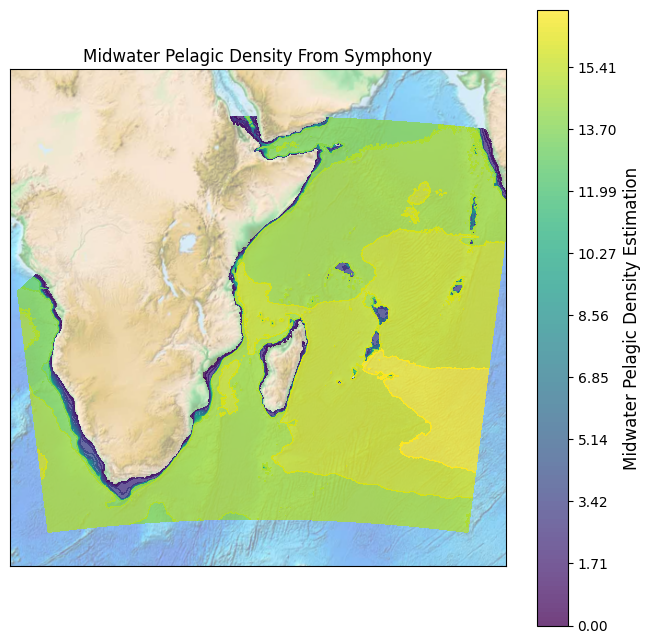

In [8]:
#We have a quick visualisation to the data
fig = plt.figure(figsize=(8, 8))

m = Basemap(projection='lcc', resolution=None,
            width=8E6, height=8E6, 
            lat_0=(lat[0]+lat[-1])/2, lon_0=(lon[0]+lon[-1])/2,)

longitude, latitude = np.meshgrid(lon, lat)
x, y = m(longitude, latitude)

m.etopo(scale=0.5, alpha=0.5)

plt.contourf(x, y, eco_masked, alpha=0.75, levels=np.linspace(0,np.max(eco_masked),140),
             cmap=plt.cm.viridis)

plt.colorbar().set_label(label="Midwater Pelagic Density Estimation", fontsize=12)

plt.title("Midwater Pelagic Density From Symphony")

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0.5, 1.0, 'Air Pollution')

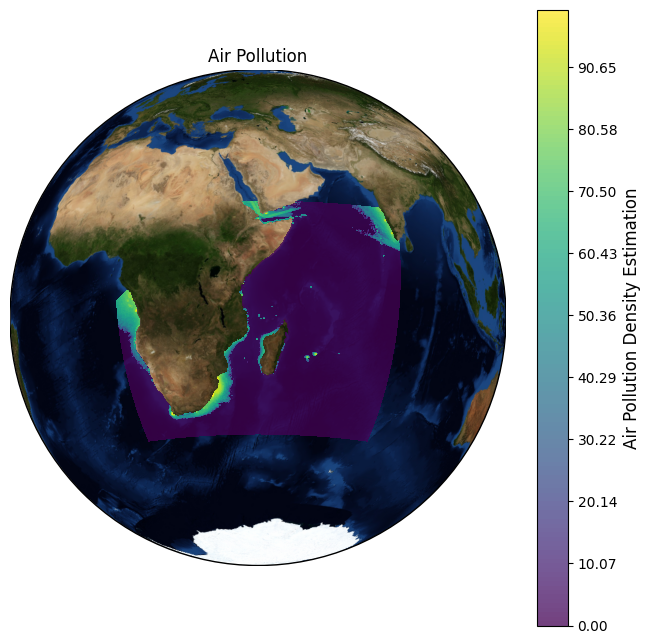

In [9]:
#Just for fun we check on a different projection
plt.figure(figsize=(8, 8))

m = Basemap(projection='ortho', resolution=None, lat_0=(lat[0]+lat[-1])/2, lon_0=(lon[0]+lon[-1])/2)

m.bluemarble(scale=0.5)

longitude, latitude = np.meshgrid(lon, lat)
x, y = m(longitude, latitude)

plt.contourf(x, y, pres_masked, alpha=0.75, levels=np.linspace(0,np.max(pres_masked),140),
             cmap=plt.cm.viridis)

plt.colorbar().set_label(label="Air Pollution Density Estimation", fontsize=12)

plt.title("Air Pollution")


# Symphony Species data 

We load and wanna match the name from the Symphony *.tif data and 

In [10]:
#The variable name is mapped to their corresponding file path in pres_name and eco_name. We load the data according to the filepath...
index_ecosystem_sensitivity = df_sensitivity.index.get_level_values(1)
index_pressure_sensitivity = df_sensitivity.columns.get_level_values(1)

#We store the data from the tif image in a numpy array. This operation is expensive...
data_ecosystem = generate_eco_or_pres_matrix(eco_name, index_ecosystem_sensitivity, lat, lon)
data_pressure = generate_eco_or_pres_matrix(pres_name, index_pressure_sensitivity, lat, lon)

In [11]:
#An example of aggregation with the numpy array would be as follow
ind_shipping = np.where(df_sensitivity.columns.get_level_values(0)=='SHIPPING ')[0]
ind_fishing = np.where(df_sensitivity.columns.get_level_values(0)=='FISHING')[0]

cumulative_pressure_shipping = np.sum(data_pressure[ind_shipping,:], axis=0)
cumulative_pressure_fishing = np.sum(data_pressure[ind_fishing,:], axis=0)

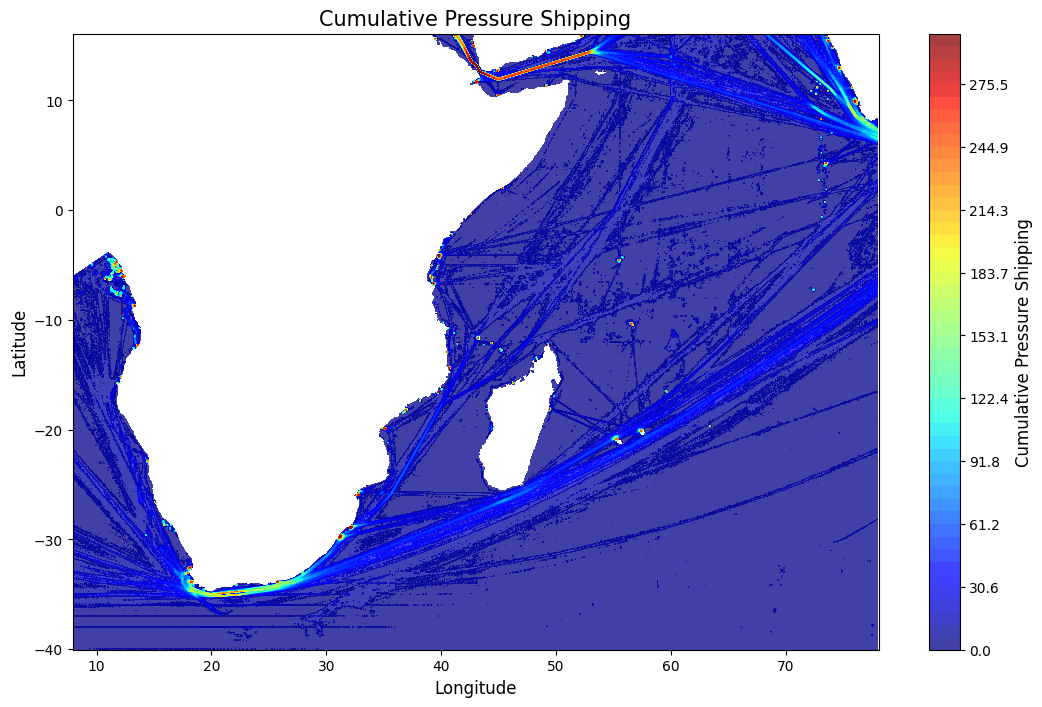

In [12]:
#We can create a figure for the cumulative shipping
plot_symphony(lon, lat, cumulative_pressure_shipping, label_colorbar="Cumulative Pressure Shipping"
              , title="Cumulative Pressure Shipping", savefig_path="figures/cumulative_impact_shipping.jpeg", show=True)

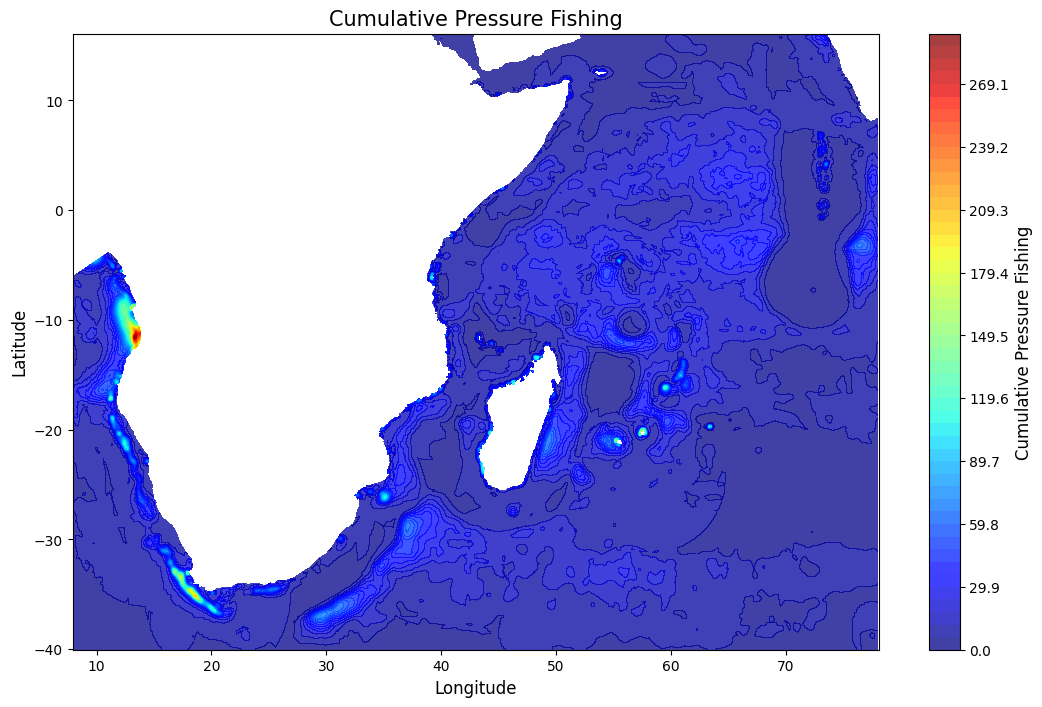

In [13]:
plot_symphony(lon, lat, cumulative_pressure_fishing, label_colorbar="Cumulative Pressure Fishing"
              , title="Cumulative Pressure Fishing", savefig_path="figures/cumulative_impact_fishing.jpeg", show=True)

In [14]:
plot_and_save_all = False
index = df_sensitivity.index.get_level_values(1)

if plot_and_save_all:
    for i, name in enumerate(index):
        
        fig = plt.figure(figsize=(8, 8))
        name_save = name[0].upper()+name[1::]
        m = Basemap(projection='lcc', resolution=None,
                    width=8E6, height=8E6, 
                    lat_0=(lat[0]+lat[-1])/2, lon_0=(lon[0]+lon[-1])/2,)
        
        longitude, latitude = np.meshgrid(lon, lat)
        x, y = m(longitude, latitude)
        
        m.etopo(scale=0.5, alpha=0.5)
        
        plt.contourf(x, y, sensitive_area[i,:], alpha=0.75, levels=np.linspace(0,np.max(sensitive_area[i,:]),140),
                     cmap=plt.cm.viridis)
        
        plt.colorbar().set_label(label="{} Density Estimation".format(name_save), fontsize=12)
        plt.title("Sensitive Area for {} under Pressure of Shipping".format(name_save))
        plt.savefig("figures/{}_shipping.jpeg".format(name_save), dpi=250)
        plt.close()

In [15]:
#We aggregate the sensitivity matrix according to the pressure category: e.g Algae Farming & Mariculture for the Aquaculture category
#Or ship pollution, ship strike, underwater noise for Shipping
df_sum = df_sensitivity.groupby(axis=1,level=0).sum()

shipping = df_sum['SHIPPING ']
sensitive_area = np.zeros_like(data_ecosystem)
for i, value in enumerate(shipping):
    sensitive_area[i,:] = value*data_ecosystem[i,:]

sum_shipping=np.sum(sensitive_area, axis=0)

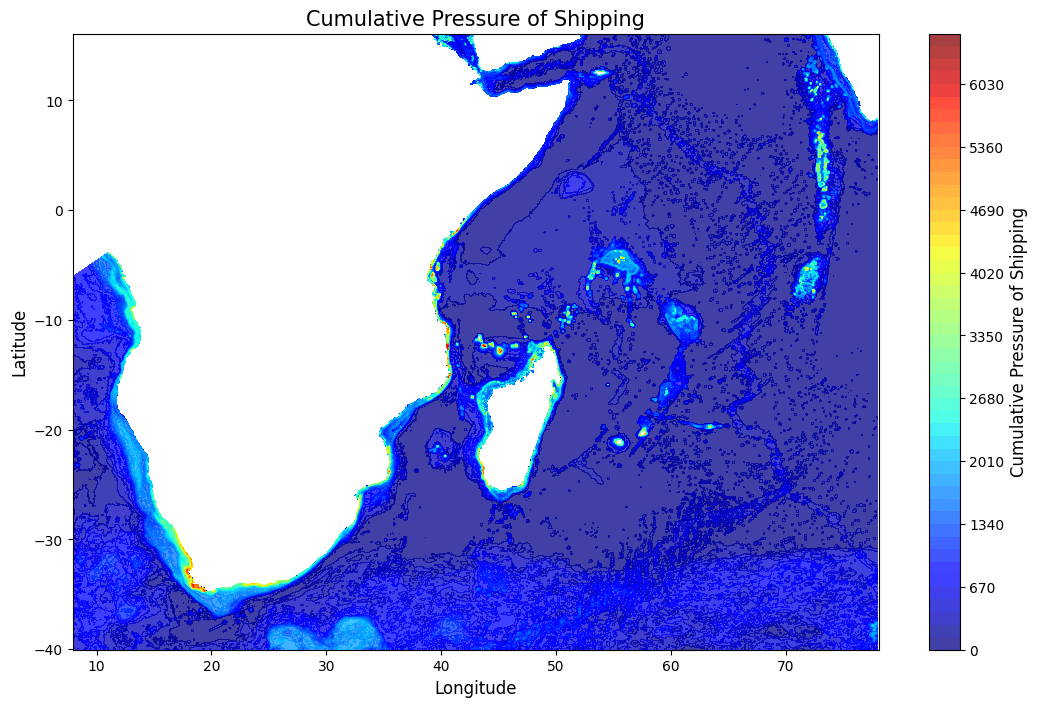

In [16]:
#Visualisation of the cumulative shipping impact on e
plot_symphony(lon, lat, sum_shipping, label_colorbar="Cumulative Pressure of Shipping"
              , title="Cumulative Pressure of Shipping", savefig_path=None, show=True)

In [17]:
#Let's clean up some space
del sum_shipping

In [18]:
fishing = df_sum['FISHING']
sensitive_area_fishing = np.zeros_like(data_ecosystem)
for i, value in enumerate(fishing):
    sensitive_area_fishing[i,:] = value*data_ecosystem[i,:]

sum_fishing=np.sum(sensitive_area_fishing, axis=0)

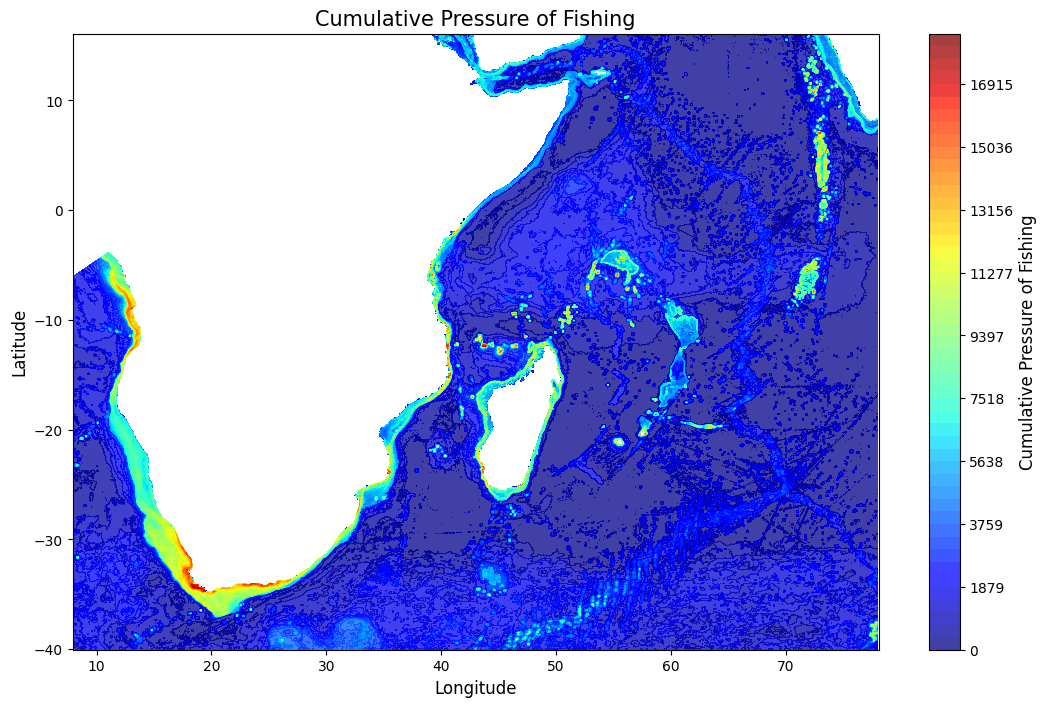

In [19]:
#Visualisation of the cumulative shipping impact on e
plot_symphony(lon, lat, sum_fishing, label_colorbar="Cumulative Pressure of Fishing"
              , title="Cumulative Pressure of Fishing", savefig_path=None, show=True)

# Data storage example

In [20]:
# MultiIndex for the first DataArray
index_ecosystem = pd.MultiIndex.from_tuples(list(df_sensitivity.index), names=["eco_category", "eco_subcategory"])
# MultiIndex for the second DataArray
index_pressure = pd.MultiIndex.from_tuples(list(df_sensitivity.columns), names=["pressure_type", "pressure_subtype"])

# Create the DataArrays
data_array_ecosystem = xr.DataArray(data_ecosystem, coords=[index_ecosystem, lat, lon], dims=["pressure", "latitude", "longitude"])
data_array_pressure = xr.DataArray(data_pressure, coords=[index_pressure, lat, lon], dims=["ecosystem", "latitude", "longitude"])

# Combine into a Dataset
ds = xr.Dataset({
    "Ecosystem_map": data_array_ecosystem,
    "Pressure_map": data_array_pressure, 
})

ds.attrs['title'] = 'Symphony Data'
ds.attrs['institution'] = 'WIO'
ds.attrs['source'] = 'https://github.com/WIOSymphony/wiosym/tree/main/products/v2.1/output_geotiffs'
ds.attrs['history'] = 'Created on ' + pd.Timestamp.now().strftime('%Y-%m-%d')


In [21]:
data_array_sensitivity = xr.DataArray(df_sensitivity.values, coords=[index_ecosystem, index_pressure], 
                                      dims=["ecosystem_sensitivity", "pressure_sensitivity"])


In [22]:
#TODO: Create the netcdf to integrate the postgres database from marine protected areas to this dataset
#YOUR_DATA_PATH='/data/WIO_Symphony/'
#ds.to_netcdf(YOUR_DATA_PATH+'WIO_symphony.nc')

In [23]:
#TODO: Dask integration to the dataset. It should not be long to do since dask is integrated to xarray
#ds.chunks({'latitude': X, 'longitude': Y})